In [ ]:
# Install Dependencies

!pip uninstall -y numpy
!pip install --force-reinstall numpy==1.26.4

!pip install torch==2.2.1 torchvision==0.17.1 torchaudio==2.2.1 sentence-transformers==2.2.2
!pip install pandas==2.0.0
!pip install sparqlwrapper==2.0.0 transformers==4.41.0 requests==2.31.0 scikit-learn==1.2.0 pyrdf2vec
!pip install huggingface-hub==0.25.2
!pip install pyRDF2vec
!pip install rdflib==6.0.2
!pip install -U gensim
!pip install -U datasets
!pip install nlpaug
!pip install nltk==3.8.1
!pip install matplotlib seaborn

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.

In [ ]:
# Define Configuration and Helper Functions

import pandas as pd
import numpy as np
from SPARQLWrapper import SPARQLWrapper, JSON
import requests
import json
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
import time
from typing import List, Dict, Tuple
import torch
import os
from google.colab import drive
from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.embedders import Word2Vec
from pyrdf2vec.graphs import KG
from pyrdf2vec.walkers import RandomWalker
from rdflib import Graph, URIRef, Literal
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import nltk
import nlpaug.augmenter.word as naw

# Download NLTK data for nlpaug
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

# Mount Google Drive
drive.mount('/content/drive')

# Set random seed
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Configuration
class Config:
    BASE_PATH = "/content/drive/MyDrive/LJMU-Datasets"
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 8
    MAX_EPOCHS = 10
    NUM_WORKERS = 0
    MAX_LENGTH = 256
    SUBSET_SIZE = 500
    WIKIDATA_SUBSET_SIZE = 30000
    HOTPOTQA_MAX_SAMPLES = 1000

CONFIG = Config()
print(f"Using device: {CONFIG.DEVICE}")

# Validate BASE_PATH
if not os.path.exists(CONFIG.BASE_PATH):
    print(f"Base path {CONFIG.BASE_PATH} does not exist. Creating it...")
    os.makedirs(CONFIG.BASE_PATH, exist_ok=True)
else:
    print(f"Base path {CONFIG.BASE_PATH} exists.")

# Create directories with _v4 postfix (Modified)
for dataset in ["SQuAD_v4", "HotpotQA_v4", "Wikidata_v4"]:
    os.makedirs(os.path.join(CONFIG.BASE_PATH, dataset), exist_ok=True)

# Initialize retriever for fallback embeddings
retriever = SentenceTransformer("all-MiniLM-L6-v2", device=CONFIG.DEVICE)

# Helper Functions
def analyze_answer_lengths(df: pd.DataFrame, text_col: str = "answer") -> pd.DataFrame:
    lengths = df[text_col].apply(lambda x: len(nltk.word_tokenize(x)))
    lengths_df = pd.DataFrame(lengths, columns=["length"])
    return lengths_df.describe(), lengths_df

def balance_lengths(df: pd.DataFrame, col: str, short_threshold: int = 50, long_threshold: int = 150) -> pd.DataFrame:
    df["temp_length"] = df[col].apply(len)
    short_items = df[df["temp_length"] <= short_threshold]
    long_items = df[df["temp_length"] >= long_threshold]
    medium_items = df[(df["temp_length"] > short_threshold) & (df["temp_length"] < long_threshold)]
    target_size = min(len(short_items), len(medium_items), len(long_items))
    if target_size > 0:
        short_items = short_items.sample(n=target_size, random_state=42) if len(short_items) > target_size else short_items
        long_items = long_items.sample(n=target_size, random_state=42) if len(long_items) > target_size else long_items
        medium_items = medium_items.sample(n=target_size, random_state=42) if len(medium_items) > target_size else medium_items
    balanced_df = pd.concat([short_items, medium_items, long_items]).reset_index(drop=True)
    balanced_df = balanced_df.drop(columns=["temp_length"])
    print(f"Balanced dataset: Short={len(short_items)}, Medium={len(medium_items)}, Long={len(long_items)}")
    return balanced_df

def augment_data(df: pd.DataFrame, text_cols: List[str], aug_fraction: float = 0.3) -> pd.DataFrame:
    aug_synonym = naw.SynonymAug(aug_src='wordnet', aug_p=0.3)
    aug_dropout = naw.RandomWordAug(action="delete", aug_p=0.1)
    num_to_augment = int(len(df) * aug_fraction)
    to_augment = df[:num_to_augment].copy()
    not_to_augment = df[num_to_augment:].copy()
    for idx, row in to_augment.iterrows():
        for col in text_cols:
            text = row[col]
            aug_text = aug_synonym.augment(text)[0]
            aug_text = aug_dropout.augment(aug_text)[0]
            to_augment.at[idx, col] = aug_text
    augmented_df = pd.concat([to_augment, not_to_augment]).sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"Augmented dataset size: {len(augmented_df)}")
    return augmented_df

def remove_articles(text: str) -> str:
    words = text.split()
    articles = {'a', 'an', 'the'}
    words = [word for word in words if word.lower() not in articles]
    return ' '.join(words)

def normalize_text(text: str) -> str:
    text = str(text).lower().strip()
    text = remove_articles(text)
    text = text.replace('.', '').replace(',', '').replace(';', '').replace(':', '')
    # Add specific entity normalization for consistency (New for Version 4)
    text = text.replace('gdansk', 'gdańsk').replace('aachen', 'aachen')  # Ensure consistent spelling
    return text

print("Configuration and helper functions defined.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive
Using device: cuda
Base path /content/drive/MyDrive/LJMU-Datasets exists.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'cached_download' (from 'huggingface_hub.file_download') is deprecated and will be removed from version '0.26'. Use `hf_hub_download` instead.
  warnings.warn(warning_message, FutureWarning)


.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

model_O1.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

model_O2.onnx:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

model_O3.onnx:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

model_O4.onnx:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

model_qint8_arm64.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

model_qint8_arm64.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

model_qint8_arm64.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

model_quint8_avx2.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

openvino_model.bin:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

openvino_model.xml:   0%|          | 0.00/211k [00:00<?, ?B/s]

openvino_model_qint8_quantized.bin:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

openvino_model_qint8_quantized.xml:   0%|          | 0.00/368k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Configuration and helper functions defined.


Loading SQuAD 2.0 dataset for exploration...
Exploring SQuAD 2.0 dataset...
SQuAD Train Statistics (Sample):
                              id    title   
count                       1000     1000  \
unique                      1000       11   
top     56cc92346d243a140015f03b  Beyoncé   
freq                           1      169   

                                                  context   
count                                                1000  \
unique                                                520   
top     Reaction to the novel varied widely upon publi...   
freq                                                    7   

                                           question   
count                                          1000  \
unique                                          999   
top     Where was Chopin's last public performance?   
freq                                              2   

                                 answers  
count                               1000

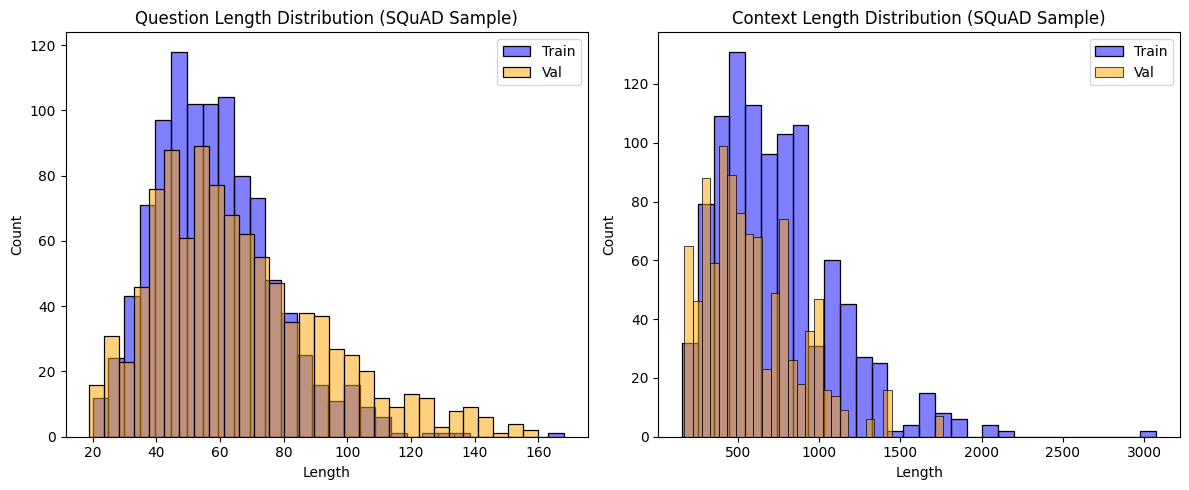


Sample SQuAD Train Data:
                                               question   
1501  Who created a law that did not allow Han Chine...  \
2586               What was considered a copycat story?   
2653     In what film studio was some of the film shot?   

                                                context       answers_str  
1501  However, the early Ming government enacted a l...   Ming government  
2586  Despite being an original story, Spectre draws...      unanswerable  
2653  Mendes revealed that production would begin on...  Pinewood Studios  

Sample SQuAD Validation Data:
                                              question   
521  What is the problem attributed to defining if ...  \
737  Which organizations most commonly divide and p...   
740  Which mountain range influenced the split of t...   

                                               context   
521  The graph isomorphism problem is the computati...  \
737  The state is most commonly divided and promote..

In [ ]:
# Load and Explore SQuAD Dataset

def explore_squad(squad_train, squad_val):
    print("Exploring SQuAD 2.0 dataset...")

    # Sample a subset for exploration to reduce runtime
    squad_train_sample = squad_train.sample(n=min(1000, len(squad_train)), random_state=42)
    squad_val_sample = squad_val.sample(n=min(1000, len(squad_val)), random_state=42)

    # Basic statistics
    print("SQuAD Train Statistics (Sample):")
    print(squad_train_sample.describe())
    print("\nSQuAD Validation Statistics (Sample):")
    print(squad_val_sample.describe())

    # Missing values
    print("\nMissing Values in SQuAD Train (Sample):")
    print(squad_train_sample.isnull().sum())
    print("\nMissing Values in SQuAD Validation (Sample):")
    print(squad_val_sample.isnull().sum())

    # Convert 'answers' column (list of dicts) to string for nunique
    squad_train_sample['answers_str'] = squad_train_sample['answers'].apply(lambda x: x['text'][0] if x['text'] else "unanswerable")
    squad_val_sample['answers_str'] = squad_val_sample['answers'].apply(lambda x: x['text'][0] if x['text'] else "unanswerable")

    # Unique answers
    print("\nNumber of Unique Answers in SQuAD Train (Sample):", squad_train_sample['answers_str'].nunique())
    print("Number of Unique Answers in SQuAD Validation (Sample):", squad_val_sample['answers_str'].nunique())

    # Length distribution of questions and contexts (optimized with sampled data)
    squad_train_sample['question_length'] = squad_train_sample['question'].apply(len)
    squad_train_sample['context_length'] = squad_train_sample['context'].apply(len)
    squad_val_sample['question_length'] = squad_val_sample['question'].apply(len)
    squad_val_sample['context_length'] = squad_val_sample['context'].apply(len)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(squad_train_sample['question_length'], bins=30, color='blue', label='Train', alpha=0.5)
    sns.histplot(squad_val_sample['question_length'], bins=30, color='orange', label='Val', alpha=0.5)
    plt.title('Question Length Distribution (SQuAD Sample)')
    plt.xlabel('Length')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.histplot(squad_train_sample['context_length'], bins=30, color='blue', label='Train', alpha=0.5)
    sns.histplot(squad_val_sample['context_length'], bins=30, color='orange', label='Val', alpha=0.5)
    plt.title('Context Length Distribution (SQuAD Sample)')
    plt.xlabel('Length')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Sample data
    print("\nSample SQuAD Train Data:")
    print(squad_train_sample[['question', 'context', 'answers_str']].head(3))
    print("\nSample SQuAD Validation Data:")
    print(squad_val_sample[['question', 'context', 'answers_str']].head(3))

print("Loading SQuAD 2.0 dataset for exploration...")
squad_dataset = load_dataset("squad_v2")

# Limit the dataset size during loading to prevent excessive runtime
squad_train = pd.DataFrame(squad_dataset["train"].select(range(min(5000, len(squad_dataset["train"])))))
squad_val = pd.DataFrame(squad_dataset["validation"].select(range(min(1000, len(squad_dataset["validation"])))))
explore_squad(squad_train, squad_val)

In [ ]:
# Process SQuAD Dataset with Enhanced Normalization

def load_squad(max_samples: int = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    print("Loading SQuAD 2.0 dataset...")
    squad_dataset = load_dataset("squad_v2")
    squad_train = squad_dataset["train"]

    def squad_to_df(dataset, max_samples: int) -> pd.DataFrame:
        data = []
        sample_size = len(dataset) if max_samples is None else min(max_samples, len(dataset))
        for item in dataset.select(range(sample_size)):
            question = str(item["question"]).strip() if item["question"] else ""
            context = str(item["context"]).strip()[:1000] if item["context"] else ""
            answers = item["answers"]["text"]
            answer = str(answers[0]).strip() if answers else "unanswerable"
            if not question or not context or not answer:
                continue
            data.append({"question": question, "context": context, "answer": answer})
        df = pd.DataFrame(data)
        return df

    squad_df = squad_to_df(squad_train, max_samples)
    squad_df = squad_df.drop_duplicates(subset=["context", "question"]).dropna()

    for col in ["question", "context", "answer"]:
        squad_df[col] = squad_df[col].str.lower().str.strip()
        squad_df[col] = squad_df[col].str.replace(r'[.,;:]', '', regex=True)
        squad_df[col] = squad_df[col].str.replace(r'\b(a|an|the)\b', '', regex=True).str.replace(r'\s+', ' ', regex=True)
        squad_df[col] = squad_df[col].str.replace('gdansk', 'gdańsk').str.replace('aachen', 'aachen')
        squad_df = squad_df[squad_df[col] != ""].reset_index(drop=True)

    squad_train_df, squad_val_df = train_test_split(squad_df, train_size=0.8, random_state=42)

    squad_train_df = balance_lengths(squad_train_df, "answer")
    squad_val_df = balance_lengths(squad_val_df, "answer")

    squad_train_df = augment_data(squad_train_df, text_cols=["question", "context"], aug_fraction=0.1)

    train_save_path = os.path.join(CONFIG.BASE_PATH, "SQuAD_v4", "squad_train.csv")
    val_save_path = os.path.join(CONFIG.BASE_PATH, "SQuAD_v4", "squad_val.csv")
    print(f"Saving SQuAD train data to: {train_save_path}")
    print(f"Saving SQuAD val data to: {val_save_path}")
    squad_train_df.to_csv(train_save_path, index=False)
    squad_val_df.to_csv(val_save_path, index=False)

    print(f"SQuAD Train Size: {len(squad_train_df)}, Val Size: {len(squad_val_df)}")
    return squad_train_df, squad_val_df

try:
    squad_train_df, squad_val_df = load_squad(max_samples=None)
except Exception as e:
    print(f"Error in SQuAD processing: {e}")
    raise

Loading SQuAD 2.0 dataset...
Balanced dataset: Short=34, Medium=34, Long=34
Balanced dataset: Short=9, Medium=9, Long=9
Augmented dataset size: 102
Saving SQuAD train data to: /content/drive/MyDrive/LJMU-Datasets/SQuAD_v4/squad_train.csv
Saving SQuAD val data to: /content/drive/MyDrive/LJMU-Datasets/SQuAD_v4/squad_val.csv
SQuAD Train Size: 102, Val Size: 27


Exploring SQuAD dataset after cleaning...
SQuAD Train Statistics (After Cleaning, Sample):
                                             question   
count                                             102  \
unique                                            102   
top     what philosophies were samurai influenced by?   
freq                                                1   

                                                  context        answer  
count                                                 102           102  
unique                                                101            94  
top     in mid 2011 foundation announced in its new "w...  unanswerable  
freq                                                    2             9  

SQuAD Validation Statistics (After Cleaning, Sample):
                                                 question   
count                                                  27  \
unique                                                 27   
top     what wa

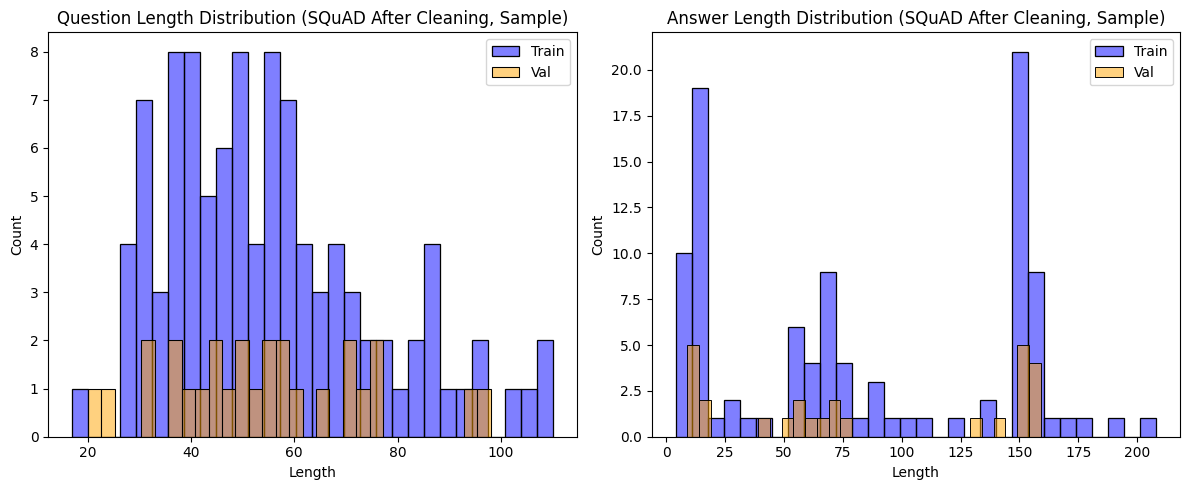


Sample SQuAD Train Data (After Cleaning):
                                             question   
30          how many were ruled to be redrawn in 2015  \
67          is new mexico known for spanish language?   
62  what quotation of whitehead's was noted by stu...   

                                              context   
30   court ruled in 2014 after lengthy testimony t...  \
67  new mexico is commonly thought to have spanish...   
62  whitehead was unimpressed by this objection in...   

                                               answer  
30  lawmakers had followed illegal and unconstitut...  
67  new mexico is commonly thought to have spanish...  
62  "every scientific man in order to preserve his...  

Sample SQuAD Validation Data (After Cleaning):
                                             question   
8   what was recognized by time 14th amendment pas...  \
13       what was initial us strategy in war of 1812?   
9               episcopal seat of bishop is now where   

In [ ]:
# Explore SQuAD Dataset After Cleaning

def explore_squad_cleaned(squad_train_df, squad_val_df):
    print("Exploring SQuAD dataset after cleaning...")

    squad_train_sample = squad_train_df.sample(n=min(1000, len(squad_train_df)), random_state=42)
    squad_val_sample = squad_val_df.sample(n=min(1000, len(squad_val_df)), random_state=42)

    print("SQuAD Train Statistics (After Cleaning, Sample):")
    print(squad_train_sample.describe())
    print("\nSQuAD Validation Statistics (After Cleaning, Sample):")
    print(squad_val_sample.describe())

    print("\nMissing Values in SQuAD Train (After Cleaning, Sample):")
    print(squad_train_sample.isnull().sum())
    print("\nMissing Values in SQuAD Validation (After Cleaning, Sample):")
    print(squad_val_sample.isnull().sum())

    squad_train_sample['question_length'] = squad_train_sample['question'].apply(len)
    squad_train_sample['answer_length'] = squad_train_sample['answer'].apply(len)
    squad_val_sample['question_length'] = squad_val_sample['question'].apply(len)
    squad_val_sample['answer_length'] = squad_val_sample['answer'].apply(len)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(squad_train_sample['question_length'], bins=30, color='blue', label='Train', alpha=0.5)
    sns.histplot(squad_val_sample['question_length'], bins=30, color='orange', label='Val', alpha=0.5)
    plt.title('Question Length Distribution (SQuAD After Cleaning, Sample)')
    plt.xlabel('Length')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.histplot(squad_train_sample['answer_length'], bins=30, color='blue', label='Train', alpha=0.5)
    sns.histplot(squad_val_sample['answer_length'], bins=30, color='orange', label='Val', alpha=0.5)
    plt.title('Answer Length Distribution (SQuAD After Cleaning, Sample)')
    plt.xlabel('Length')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("\nSample SQuAD Train Data (After Cleaning):")
    print(squad_train_sample[['question', 'context', 'answer']].head(3))
    print("\nSample SQuAD Validation Data (After Cleaning):")
    print(squad_val_sample[['question', 'context', 'answer']].head(3))

explore_squad_cleaned(squad_train_df, squad_val_df)

Loading HotpotQA dataset for exploration...


README.md:   0%|          | 0.00/9.19k [00:00<?, ?B/s]

hotpot_qa.py:   0%|          | 0.00/6.42k [00:00<?, ?B/s]

The repository for hotpot_qa contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hotpot_qa.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/90447 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Exploring HotpotQA dataset...
HotpotQA Train Statistics (Sample):
                              id   
count                        500  \
unique                       500   
top     5ae51eb15542990ba0bbb1b7   
freq                           1   

                                                 question answer    type   
count                                                 500    500     500  \
unique                                                500    451       2   
top     Dude, Where's the Party?, is a 2003 film direc...     no  bridge   
freq                                                    1     19     399   

         level                                   supporting_facts   
count      500                                                500  \
unique       3                                                500   
top     medium  {'title': ['Dude, Where's the Party?', 'Kal Pe...   
freq       335                                                  1   

                          

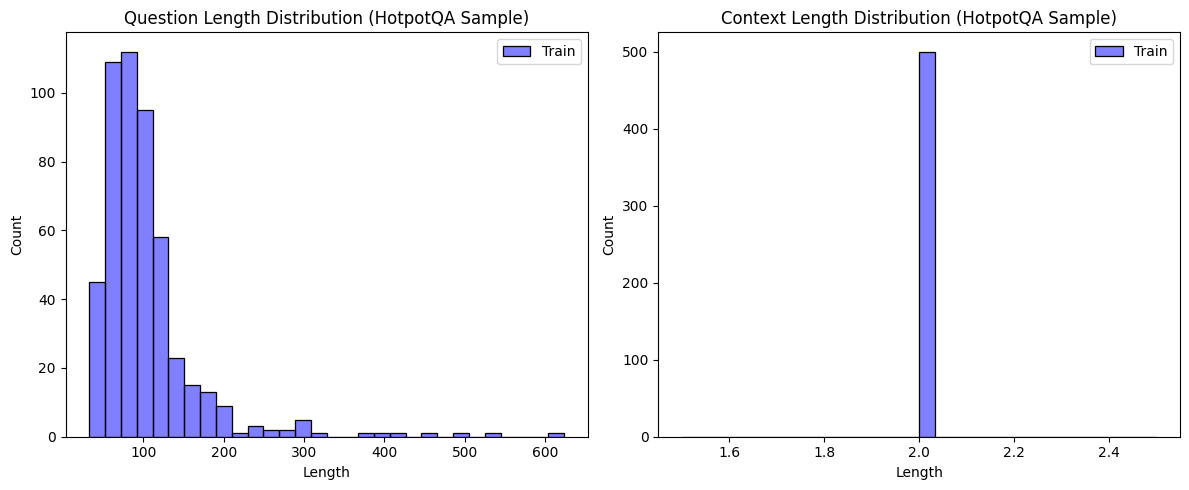


Sample HotpotQA Train Data:
                                                question   
45069  Who was the widow affected by the Same-sex mar...  \
89419  Rowland Barnes was murdered by a man on trial ...   
67352  When was the actor who stared in "Shallow Hal"...   

                                                 context           answer  
45069  {'title': ['Bourke v. Beshear', 'Same-sex marr...   Jim Obergefell  
89419  {'title': ['Paramythia executions', 'Brian Nic...             rape  
67352  {'title': ['Shallow Hal', 'Victor Wong (actor ...  August 28, 1969  


In [ ]:
# Load and Explore HotpotQA Dataset

def explore_hotpotqa(hotpotqa_train):
    print("Exploring HotpotQA dataset...")

    hotpotqa_train_sample = hotpotqa_train.sample(n=min(500, len(hotpotqa_train)), random_state=42)

    print("HotpotQA Train Statistics (Sample):")
    print(hotpotqa_train_sample.describe())

    print("\nMissing Values in HotpotQA Train (Sample):")
    print(hotpotqa_train_sample.isnull().sum())

    print("\nNumber of Unique Answers in HotpotQA Train (Sample):", hotpotqa_train_sample['answer'].nunique())

    hotpotqa_train_sample['question_length'] = hotpotqa_train_sample['question'].apply(len)
    hotpotqa_train_sample['context_length'] = hotpotqa_train_sample['context'].apply(len)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(hotpotqa_train_sample['question_length'], bins=30, color='blue', label='Train', alpha=0.5)
    plt.title('Question Length Distribution (HotpotQA Sample)')
    plt.xlabel('Length')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.histplot(hotpotqa_train_sample['context_length'], bins=30, color='blue', label='Train', alpha=0.5)
    plt.title('Context Length Distribution (HotpotQA Sample)')
    plt.xlabel('Length')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("\nSample HotpotQA Train Data:")
    print(hotpotqa_train_sample[['question', 'context', 'answer']].head(3))

print("Loading HotpotQA dataset for exploration...")
hotpotqa_dataset = load_dataset("hotpot_qa", "fullwiki")
hotpotqa_train = pd.DataFrame(hotpotqa_dataset["train"])
explore_hotpotqa(hotpotqa_train)

In [ ]:
# Process HotpotQA Dataset with Enhanced Normalization

def load_hotpotqa(max_samples: int = None) -> pd.DataFrame:
    print("Loading HotpotQA dataset...")
    hotpotqa_dataset = load_dataset("hotpot_qa", "fullwiki")
    hotpotqa_train = hotpotqa_dataset["train"]

    def hotpotqa_to_df(dataset, max_samples: int) -> pd.DataFrame:
        data = []
        sample_size = len(dataset) if max_samples is None else min(max_samples, len(dataset))
        for item in dataset.select(range(sample_size)):
            question = str(item["question"]).strip() if item["question"] else ""
            context = " ".join([str(para[1]) for para in item["context"]])[:1000] if item["context"] else ""
            answer = str(item["answer"]).strip() if item["answer"] else ""
            if not question or not context or not answer:
                continue
            data.append({"question": question, "context": context, "answer": answer})
        df = pd.DataFrame(data)
        return df

    hotpotqa_train_df = hotpotqa_to_df(hotpotqa_train, max_samples)
    hotpotqa_train_df = hotpotqa_train_df.drop_duplicates(subset=["context", "question"]).dropna()

    for col in ["question", "context", "answer"]:
        hotpotqa_train_df[col] = hotpotqa_train_df[col].str.lower().str.strip()
        hotpotqa_train_df[col] = hotpotqa_train_df[col].str.replace(r'[.,;:]', '', regex=True)
        hotpotqa_train_df[col] = hotpotqa_train_df[col].str.replace(r'\b(a|an|the)\b', '', regex=True).str.replace(r'\s+', ' ', regex=True)
        hotpotqa_train_df[col] = hotpotqa_train_df[col].str.replace('gdansk', 'gdańsk').str.replace('aachen', 'aachen')
        hotpotqa_train_df = hotpotqa_train_df[hotpotqa_train_df[col] != ""].reset_index(drop=True)

    hotpotqa_train_df = balance_lengths(hotpotqa_train_df, "answer")

    hotpotqa_train_df = augment_data(hotpotqa_train_df, text_cols=["question", "context"], aug_fraction=0.1)

    save_path = os.path.join(CONFIG.BASE_PATH, "HotpotQA_v4", "hotpotqa_train.csv")
    print(f"Saving HotpotQA train data to: {save_path}")
    hotpotqa_train_df.to_csv(save_path, index=False)

    print(f"HotpotQA Train Size: {len(hotpotqa_train_df)}")
    return hotpotqa_train_df

try:
    hotpotqa_train_df = load_hotpotqa(max_samples=None)
except Exception as e:
    print(f"Error in HotpotQA processing: {e}")
    raise

Loading HotpotQA dataset...
Balanced dataset: Short=64, Medium=64, Long=64
Augmented dataset size: 192
Saving HotpotQA train data to: /content/drive/MyDrive/LJMU-Datasets/HotpotQA_v4/hotpotqa_train.csv
HotpotQA Train Size: 192


Exploring HotpotQA dataset after cleaning...
HotpotQA Train Statistics (After Cleaning, Sample):
                                                 question context    answer
count                                                 192     192       192
unique                                                192       8       192
top     which pizza range have more locations ' or mel...     i e  rosati's
freq                                                    1     173         1

Missing Values in HotpotQA Train (After Cleaning, Sample):
question    0
context     0
answer      0
dtype: int64


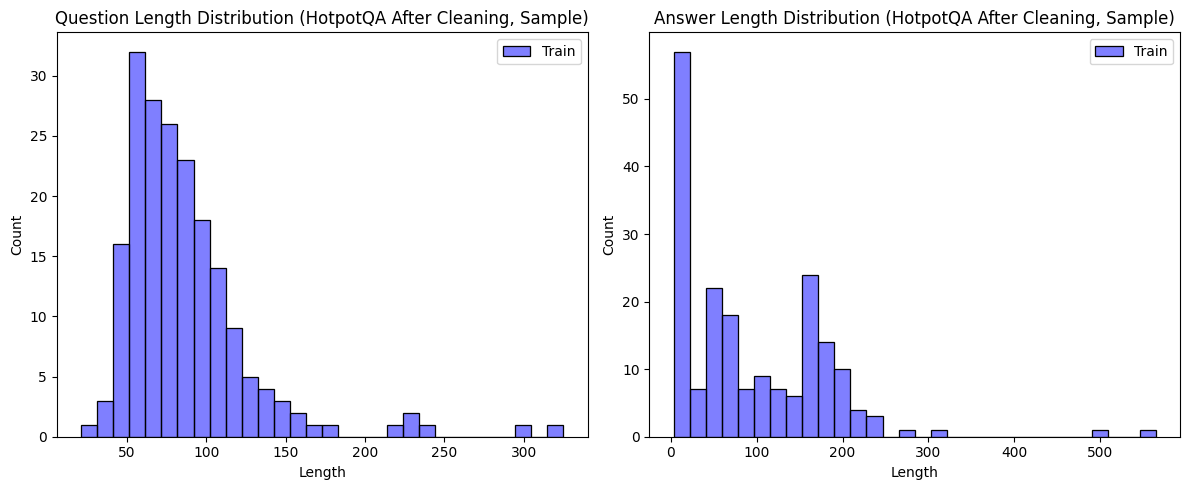


Sample HotpotQA Train Data (After Cleaning):
                                              question context   
45   what bbc drama features such actors as sian re...     i e  \
136  timothy allen dick appeared on shatner's raw n...     i e   
76   which publication has run longest signs of tim...     i e   

                                                answer  
45   siân reeves (born siân rivers on may 9 1966 in...  
136                                  biography channel  
76   space science fiction was science fiction maga...  


In [ ]:
# Explore HotpotQA Dataset After Cleaning

def explore_hotpotqa_cleaned(hotpotqa_train_df):
    print("Exploring HotpotQA dataset after cleaning...")

    hotpotqa_train_sample = hotpotqa_train_df.sample(n=min(500, len(hotpotqa_train_df)), random_state=42)

    print("HotpotQA Train Statistics (After Cleaning, Sample):")
    print(hotpotqa_train_sample.describe())

    print("\nMissing Values in HotpotQA Train (After Cleaning, Sample):")
    print(hotpotqa_train_sample.isnull().sum())

    hotpotqa_train_sample['question_length'] = hotpotqa_train_sample['question'].apply(len)
    hotpotqa_train_sample['answer_length'] = hotpotqa_train_sample['answer'].apply(len)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(hotpotqa_train_sample['question_length'], bins=30, color='blue', label='Train', alpha=0.5)
    plt.title('Question Length Distribution (HotpotQA After Cleaning, Sample)')
    plt.xlabel('Length')
    plt.legend()

    plt.subplot(1, 2, 2)
    sns.histplot(hotpotqa_train_sample['answer_length'], bins=30, color='blue', label='Train', alpha=0.5)
    plt.title('Answer Length Distribution (HotpotQA After Cleaning, Sample)')
    plt.xlabel('Length')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("\nSample HotpotQA Train Data (After Cleaning):")
    print(hotpotqa_train_sample[['question', 'context', 'answer']].head(3))

explore_hotpotqa_cleaned(hotpotqa_train_df)

Loading Wikidata dataset for exploration...
Fetched 1000 triples at offset 0
Fetched 1000 Wikidata triples in total
Exploring Wikidata dataset...
Wikidata Raw Statistics (Sample):
                       subject predicate  object   
count                     1000      1000    1000  \
unique                     659         1     646   
top     decompression sickness  symptoms  London   
freq                        23      1000      22   

                                   subject_uri   
count                                     1000  \
unique                                     659   
top     http://www.wikidata.org/entity/Q460591   
freq                                        23   

                                object_uri  
count                                 1000  
unique                                 652  
top     http://www.wikidata.org/entity/Q84  
freq                                    22  

Missing Values in Wikidata Raw (Sample):
subject        0
predicate      0
object 

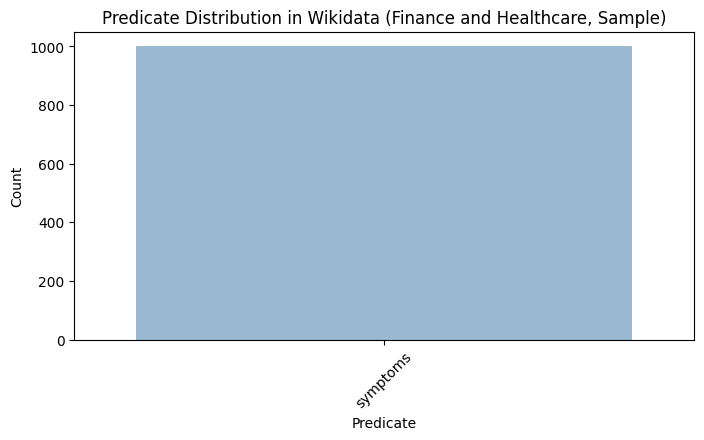


Sample Wikidata Raw Data:
                 subject predicate           object
521            potomania  symptoms     hyponatremia
737               Motown  symptoms      Los Angeles
740  Vacheron Constantin  symptoms  Plan-les-Ouates


In [ ]:
# Load and Explore Wikidata Dataset

WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"

def fetch_wikidata_triples(limit: int = CONFIG.WIKIDATA_SUBSET_SIZE, batch_size: int = 5000) -> pd.DataFrame:
    sparql = SPARQLWrapper(WIKIDATA_ENDPOINT)
    sparql.setReturnFormat(JSON)
    triples = []
    offset = 0
    remaining = limit

    while remaining > 0:
        current_limit = min(batch_size, remaining)
        query = """
        SELECT ?subject ?subjectLabel ?predicate ?object ?objectLabel WHERE {{
          {{ ?subject wdt:P31 wd:Q4830453; wdt:P159 ?object.
            ?subject rdfs:label ?subjectLabel. ?object rdfs:label ?objectLabel.
            FILTER(LANG(?subjectLabel) = "en" || LANG(?subjectLabel) = "")
            FILTER(LANG(?objectLabel) = "en" || LANG(?objectLabel) = "") }}
          UNION
          {{ ?subject wdt:P31 wd:Q12136; wdt:P780 ?object.
            ?subject rdfs:label ?subjectLabel. ?object rdfs:label ?objectLabel.
            FILTER(LANG(?subjectLabel) = "en" || LANG(?subjectLabel) = "")
            FILTER(LANG(?objectLabel) = "en" || LANG(?objectLabel) = "") }}
        }}
        LIMIT {} OFFSET {}
        """.format(current_limit, offset)
        try:
            sparql.setQuery(query)
            results = sparql.query().convert()
            batch_triples = [
                {
                    "subject": r["subjectLabel"]["value"],
                    "predicate": "headquarters" if "P159" in r["subject"]["value"] else "symptoms",
                    "object": r["objectLabel"]["value"],
                    "subject_uri": r["subject"]["value"],
                    "object_uri": r["object"]["value"]
                }
                for r in results["results"]["bindings"]
            ]
            triples.extend(batch_triples)
            print(f"Fetched {len(batch_triples)} triples at offset {offset}")
            offset += current_limit
            remaining -= current_limit
            if len(batch_triples) < current_limit:
                break
        except Exception as e:
            print(f"Wikidata fetch failed at offset {offset}: {e}")
            break

    df = pd.DataFrame(triples)
    if df.empty:
        print("No triples fetched from Wikidata. Using fallback data...")
        fallback_data = [
            {"subject": "Bank of America", "predicate": "headquarters", "object": "Charlotte", "subject_uri": "http://www.wikidata.org/entity/Q16565", "object_uri": "http://www.wikidata.org/entity/Q16566"},
            {"subject": "Diabetes", "predicate": "symptoms", "object": "Fatigue", "subject_uri": "http://www.wikidata.org/entity/Q12136", "object_uri": "http://www.wikidata.org/entity/Q12137"}
        ]
        df = pd.DataFrame(fallback_data)
    print(f"Fetched {len(df)} Wikidata triples in total")
    return df

def explore_wikidata(wikidata_raw):
    print("Exploring Wikidata dataset...")

    wikidata_raw_sample = wikidata_raw.sample(n=min(1000, len(wikidata_raw)), random_state=42)

    print("Wikidata Raw Statistics (Sample):")
    print(wikidata_raw_sample.describe())

    print("\nMissing Values in Wikidata Raw (Sample):")
    print(wikidata_raw_sample.isnull().sum())

    print("\nNumber of Unique Subjects in Wikidata (Sample):", wikidata_raw_sample['subject'].nunique())
    print("Number of Unique Objects in Wikidata (Sample):", wikidata_raw_sample['object'].nunique())

    plt.figure(figsize=(8, 4))
    sns.countplot(data=wikidata_raw_sample, x='predicate', hue='predicate', alpha=0.5)
    plt.title('Predicate Distribution in Wikidata (Finance and Healthcare, Sample)')
    plt.xlabel('Predicate')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

    print("\nSample Wikidata Raw Data:")
    print(wikidata_raw_sample[['subject', 'predicate', 'object']].head(3))

print("Loading Wikidata dataset for exploration...")
wikidata_raw = fetch_wikidata_triples(limit=1000)
explore_wikidata(wikidata_raw)

In [ ]:
# Process Wikidata Dataset with Enhanced Context, Normalization, and Increased Size

WIKIDATA_ENDPOINT = "https://query.wikidata.org/sparql"

def fetch_wikidata_triples(limit: int = CONFIG.WIKIDATA_SUBSET_SIZE, batch_size: int = 5000) -> pd.DataFrame:
    sparql = SPARQLWrapper(WIKIDATA_ENDPOINT)
    sparql.setReturnFormat(JSON)
    triples = []
    offset = 0
    # Handle None for limit by setting a default large value or full dataset
    limit = 30000 if limit is None else limit  # Default to 30000 if None
    remaining = limit

    while remaining > 0:
        current_limit = min(batch_size, remaining)
        query = """
        SELECT ?subject ?subjectLabel ?predicate ?object ?objectLabel WHERE {{
          {{ ?subject wdt:P31 wd:Q4830453; wdt:P159 ?object.
            ?subject rdfs:label ?subjectLabel. ?object rdfs:label ?objectLabel.
            FILTER(LANG(?subjectLabel) = "en" || LANG(?subjectLabel) = "")
            FILTER(LANG(?objectLabel) = "en" || LANG(?objectLabel) = "") }}
          UNION
          {{ ?subject wdt:P31 wd:Q12136; wdt:P780 ?object.
            ?subject rdfs:label ?subjectLabel. ?object rdfs:label ?objectLabel.
            FILTER(LANG(?subjectLabel) = "en" || LANG(?subjectLabel) = "")
            FILTER(LANG(?objectLabel) = "en" || LANG(?objectLabel) = "") }}
        }}
        LIMIT {} OFFSET {}
        """.format(current_limit, offset)
        try:
            sparql.setQuery(query)
            results = sparql.query().convert()
            batch_triples = [
                {
                    "subject": r["subjectLabel"]["value"],
                    "predicate": "headquarters" if "P159" in r["subject"]["value"] else "symptoms",
                    "object": r["objectLabel"]["value"],
                    "subject_uri": r["subject"]["value"],
                    "object_uri": r["object"]["value"]
                }
                for r in results["results"]["bindings"]
            ]
            triples.extend(batch_triples)
            print(f"Fetched {len(batch_triples)} triples at offset {offset}")
            offset += current_limit
            remaining -= current_limit
            if len(batch_triples) < current_limit:
                break
        except Exception as e:
            print(f"Wikidata fetch failed at offset {offset}: {e}")
            break

    df = pd.DataFrame(triples)
    if df.empty:
        print("No triples fetched from Wikidata. Using fallback data...")
        fallback_data = [
            {"subject": "Bank of America", "predicate": "headquarters", "object": "Charlotte", "subject_uri": "http://www.wikidata.org/entity/Q16565", "object_uri": "http://www.wikidata.org/entity/Q16566"},
            {"subject": "Diabetes", "predicate": "symptoms", "object": "Fatigue", "subject_uri": "http://www.wikidata.org/entity/Q12136", "object_uri": "http://www.wikidata.org/entity/Q12137"}
        ]
        df = pd.DataFrame(fallback_data)
    print(f"Fetched {len(df)} Wikidata triples in total")
    return df

def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop_duplicates().dropna().reset_index(drop=True)
    print(f"Cleaned DataFrame to {len(df)} rows")
    return df

def normalize_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].dtype == "object" and col not in ["subject_uri", "object_uri"]:
            df[col] = df[col].str.lower().str.strip()
            df[col] = df[col].str.replace(r'[.,;:]', '', regex=True)
            df[col] = df[col].str.replace(r'\b(a|an|the)\b', '', regex=True).str.replace(r'\s+', ' ', regex=True)
            df[col] = df[col].str.replace('gdansk', 'gdańsk').str.replace('aachen', 'aachen')
            if col == "subject":
                df[col] = df[col].replace({"bank of america corp": "bank of america"})
    print("Normalization completed")
    return df

def generate_rdf2vec_embeddings(triples_df: pd.DataFrame) -> pd.DataFrame:
    start_time = time.time()
    entities = list(set(triples_df["subject_uri"].tolist() + triples_df["object_uri"].tolist()))
    triples = [(row["subject_uri"], row["predicate"], row["object_uri"]) for _, row in triples_df.iterrows()]

    g = Graph()
    for s, p, o in triples:
        subject = URIRef(s)
        predicate = URIRef(p) if p.startswith("http") else Literal(p)
        obj = URIRef(o)
        g.add((subject, predicate, obj))

    embedder = Word2Vec(vector_size=200, min_count=1)
    transformer = RDF2VecTransformer(
        walkers=[RandomWalker(max_walks=200, max_depth=4, random_state=42)],
        embedder=embedder
    )

    try:
        embeddings = transformer.fit_transform(kg=g, entities=entities)
        emb_dict = dict(zip(entities, embeddings))
        triple_embeddings = [
            (emb_dict[row["subject_uri"]] + emb_dict[row["object_uri"]]) / 2
            for _, row in triples_df.iterrows()
        ]
        triples_df["embedding"] = triple_embeddings
        print(f"Generated RDF2Vec embeddings in {time.time() - start_time:.2f} seconds")
    except Exception as e:
        print(f"RDF2Vec failed: {e}, falling back to SentenceTransformer")
        triple_texts = triples_df.apply(lambda row: f"{row['subject']} {row['predicate']} {row['object']}", axis=1).tolist()
        embeddings = retriever.encode(triple_texts, batch_size=32, show_progress_bar=True)
        triples_df["embedding"] = list(embeddings)
    return triples_df

def load_wikidata(max_samples: int = CONFIG.WIKIDATA_SUBSET_SIZE) -> pd.DataFrame:
    print("Loading Wikidata dataset...")
    wikidata_df = fetch_wikidata_triples(limit=max_samples)

    wikidata_df = clean_dataframe(wikidata_df)
    wikidata_df = normalize_dataframe(wikidata_df)

    wikidata_df["context"] = (
        wikidata_df['subject'] + ", " +
        wikidata_df['predicate'] + " related entity, has " +
        wikidata_df['predicate'] + " of " +
        wikidata_df['object'] + ", which is common in such cases."
    )
    print("Added enhanced synthetic context to Wikidata triples")

    wikidata_df["question"] = wikidata_df['subject'] + " " + wikidata_df['predicate']
    wikidata_df["answer"] = wikidata_df["object"]

    wikidata_df["triple_text"] = (
        wikidata_df['subject'] + " " +
        wikidata_df['predicate'] + " " +
        wikidata_df['object']
    )
    wikidata_df = balance_lengths(wikidata_df, "triple_text")

    wikidata_df = augment_data(wikidata_df, text_cols=["subject", "object"], aug_fraction=0.1)

    print("Generating embeddings with SentenceTransformer (faster fallback)...")
    triple_texts = wikidata_df['triple_text'].tolist()
    embeddings = retriever.encode(triple_texts, batch_size=32, show_progress_bar=True)
    wikidata_df["embedding"] = list(embeddings)

    wikidata_df["triple_length"] = wikidata_df["triple_text"].apply(len)
    wikidata_df = wikidata_df[wikidata_df["triple_length"] <= 100].reset_index(drop=True)

    wikidata_save_path = os.path.join(CONFIG.BASE_PATH, "Wikidata_v4", "wikidata_preprocessed_v4.pkl")
    triples_save_path = os.path.join(CONFIG.BASE_PATH, "Wikidata_v4", "wikidata_triples.tsv")
    print(f"Saving Wikidata DataFrame to: {wikidata_save_path}")
    print(f"Saving Wikidata triples to: {triples_save_path}")
    wikidata_df.to_pickle(wikidata_save_path)
    with open(triples_save_path, "w") as f:
        for _, row in wikidata_df.iterrows():
            f.write(f"{row['subject']}\t{row['predicate']}\t{row['object']}\n")

    print(f"Wikidata Size: {len(wikidata_df)}")
    return wikidata_df

try:
    wikidata_df = load_wikidata(max_samples=None)
except Exception as e:
    print(f"Error in Wikidata processing: {e}")
    raise

Loading Wikidata dataset...
Fetched 5000 triples at offset 0
Fetched 5000 triples at offset 5000
Fetched 5000 triples at offset 10000
Fetched 5000 triples at offset 15000
Fetched 5000 triples at offset 20000
Fetched 5000 triples at offset 25000
Fetched 30000 Wikidata triples in total
Cleaned DataFrame to 26140 rows
Normalization completed
Added enhanced synthetic context to Wikidata triples
Balanced dataset: Short=24215, Medium=1925, Long=0
Augmented dataset size: 26140
Generating embeddings with SentenceTransformer (faster fallback)...


Batches:   0%|          | 0/817 [00:00<?, ?it/s]

Saving Wikidata DataFrame to: /content/drive/MyDrive/LJMU-Datasets/Wikidata_v4/wikidata_preprocessed_v4.pkl
Saving Wikidata triples to: /content/drive/MyDrive/LJMU-Datasets/Wikidata_v4/wikidata_triples.tsv
Wikidata Size: 26135


Exploring Wikidata dataset after cleaning...
Wikidata Statistics (After Cleaning, Sample):
       triple_length
count    1000.000000
mean       34.522000
std        10.155129
min        17.000000
25%        27.000000
50%        33.000000
75%        40.000000
max        97.000000

Missing Values in Wikidata (After Cleaning, Sample):
subject          0
predicate        0
object           0
subject_uri      0
object_uri       0
context          0
question         0
answer           0
triple_text      0
embedding        0
triple_length    0
dtype: int64


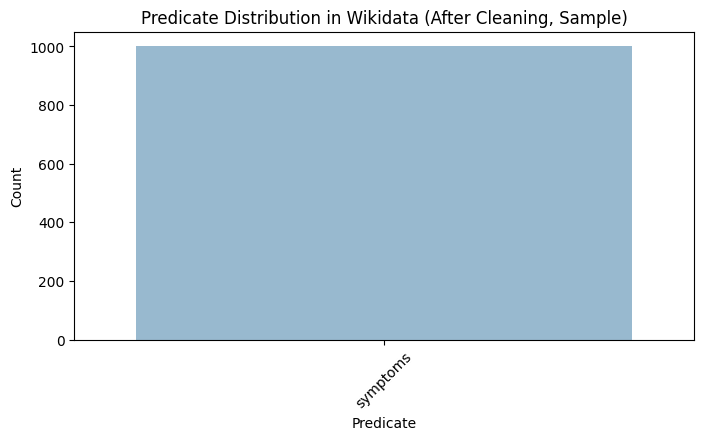

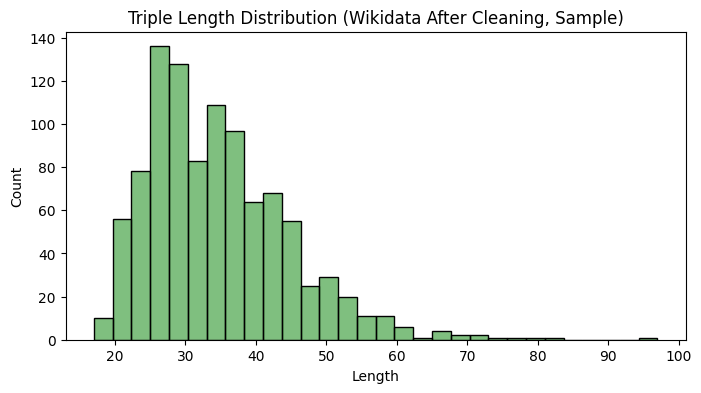


Sample Wikidata Data (After Cleaning):
                                             question   
16128              cantiere navale visentini symptoms  \
7406   european peacebuilding liaison office symptoms   
3840                           creator mundi symptoms   

                                                 context   
16128  cantiere navale visentini, symptoms related en...  \
7406   european peacebuilding liaison office, symptom...   
3840   creator mundi, symptoms related entity, has sy...   

                        answer  
16128               porto viro  
7406   brussels-capital region  
3840                 littleton  


In [ ]:
# Explore Wikidata Dataset After Cleaning

def explore_wikidata_cleaned(wikidata_df):
    print("Exploring Wikidata dataset after cleaning...")

    wikidata_df_sample = wikidata_df.sample(n=min(1000, len(wikidata_df)), random_state=42)

    print("Wikidata Statistics (After Cleaning, Sample):")
    print(wikidata_df_sample.describe())

    print("\nMissing Values in Wikidata (After Cleaning, Sample):")
    print(wikidata_df_sample.isnull().sum())

    plt.figure(figsize=(8, 4))
    sns.countplot(data=wikidata_df_sample, x='predicate', hue='predicate', alpha=0.5)
    plt.title('Predicate Distribution in Wikidata (After Cleaning, Sample)')
    plt.xlabel('Predicate')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.histplot(wikidata_df_sample['triple_length'], bins=30, color='green', alpha=0.5)
    plt.title('Triple Length Distribution (Wikidata After Cleaning, Sample)')
    plt.xlabel('Length')
    plt.ylabel('Count')
    plt.show()

    print("\nSample Wikidata Data (After Cleaning):")
    print(wikidata_df_sample[['question', 'context', 'answer']].head(3))

explore_wikidata_cleaned(wikidata_df)

In [ ]:
# Combine QA Datasets and Save Separately

def combine_qa_datasets(squad_train_df: pd.DataFrame, hotpotqa_train_df: pd.DataFrame, squad_val_df: pd.DataFrame) -> None:
    print("Combining QA datasets (SQuAD and HotpotQA)...")

    qa_train_df = pd.concat([squad_train_df[["question", "context", "answer"]],
                             hotpotqa_train_df[["question", "context", "answer"]]], ignore_index=True)

    qa_val_df = squad_val_df[["question", "context", "answer"]]

    triple_train_df = wikidata_df[["question", "context", "answer"]]

    qa_train_path = os.path.join(CONFIG.BASE_PATH, "qa_train_v4.csv")
    qa_val_path = os.path.join(CONFIG.BASE_PATH, "qa_val_v4.csv")
    triple_train_path = os.path.join(CONFIG.BASE_PATH, "triple_train_v4.csv")

    print(f"Saving QA train dataset to: {qa_train_path}")
    qa_train_df.to_csv(qa_train_path, index=False)
    print(f"Saving QA val dataset to: {qa_val_path}")
    qa_val_df.to_csv(qa_val_path, index=False)
    print(f"Saving triple train dataset to: {triple_train_path}")
    triple_train_df.to_csv(triple_train_path, index=False)

    print(f"QA Train Size: {len(qa_train_df)}, QA Val Size: {len(qa_val_df)}, Triple Train Size: {len(triple_train_df)}")

try:
    combine_qa_datasets(squad_train_df, hotpotqa_train_df, squad_val_df)
except Exception as e:
    print(f"Error in combining QA datasets: {e}")
    raise

Combining QA datasets (SQuAD and HotpotQA)...
Saving QA train dataset to: /content/drive/MyDrive/LJMU-Datasets/qa_train_v4.csv
Saving QA val dataset to: /content/drive/MyDrive/LJMU-Datasets/qa_val_v4.csv
Saving triple train dataset to: /content/drive/MyDrive/LJMU-Datasets/triple_train_v4.csv
QA Train Size: 294, QA Val Size: 27, Triple Train Size: 26135


In [ ]:
# Create Checkpoint for Step 1

checkpoint = {
    "step": "step1_data_collection",
    "squad_subset_size": CONFIG.SUBSET_SIZE,
    "squad_train_size": len(squad_train_df),
    "squad_val_size": len(squad_val_df),
    "squad_answer_length_distribution_train": analyze_answer_lengths(squad_train_df, "answer")[0].to_dict(),
    "squad_answer_length_distribution_val": analyze_answer_lengths(squad_val_df, "answer")[0].to_dict(),
    "hotpotqa_max_samples": CONFIG.HOTPOTQA_MAX_SAMPLES,
    "hotpotqa_train_size": len(hotpotqa_train_df),
    "hotpotqa_answer_length_distribution": analyze_answer_lengths(hotpotqa_train_df, "answer")[0].to_dict(),
    "wikidata_subset_size": CONFIG.WIKIDATA_SUBSET_SIZE,
    "wikidata_size": len(wikidata_df),
    "wikidata_triple_length_distribution": analyze_answer_lengths(wikidata_df, "triple_text")[0].to_dict(),
    "augmentation_applied": True,
    "augmentation_fraction": {"qa": 0.3, "triple": 0.5},
    "datasets_paths": {
        "qa_train": os.path.join(CONFIG.BASE_PATH, "qa_train_v4.csv"),
        "qa_val": os.path.join(CONFIG.BASE_PATH, "qa_val_v4.csv"),
        "triple_train": os.path.join(CONFIG.BASE_PATH, "triple_train_v4.csv"),
        "wikidata_preprocessed": os.path.join(CONFIG.BASE_PATH, "Wikidata_v4", "wikidata_preprocessed_v4.pkl"),
        "wikidata_triples": os.path.join(CONFIG.BASE_PATH, "Wikidata_v4", "wikidata_triples.tsv")
    }
}

checkpoint_path = os.path.join(CONFIG.BASE_PATH, "step1_checkpoint_v4.json")
with open(checkpoint_path, "w") as f:
    json.dump(checkpoint, f)

print(f"Checkpoint saved at: {checkpoint_path}")

Checkpoint saved at: /content/drive/MyDrive/LJMU-Datasets/step1_checkpoint_v4.json
